In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.ensemble import BaggingClassifier, BaggingRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, jaccard_score, roc_auc_score

import shap

from joblib import dump, load
import catboost as cb
from catboost import CatBoostClassifier

In [2]:
file_path = "/Users/sujitkhanna/Desktop/Courses/capstone/code base/rtb_exploration/campaign/1458/train.log.txt"
ip_features = ["weekday", "hour", "region", "slotwidth", "slotheight", "slotvisibility", "slotformat", "slotprice", "useragent"]
op_feature = ["click"]
train_size = 0.6



In [3]:
def gen_data(file_path, in_features, op_features, train_size):
    df = pd.read_csv(file_path, delimiter="\t")
    df["useragent"] = pd.factorize(df['useragent'])[0] + 1
    df["slotarea"] = df["slotwidth"]*df["slotheight"]
    in_features.remove("slotwidth")
    in_features.remove("slotheight")
    df_short = df[in_features + ["slotarea"] + op_features]
    X_train, X_test, y_train, y_test = train_test_split(df_short[in_features], df_short[op_feature[0]], test_size=1-train_size, random_state=42)
    X_train.index, X_test.index, y_train.index, y_test.index = list(range(X_train.shape[0])), list(range(X_test.shape[0])), \
                                                               list(range(y_train.shape[0])), list(range(y_test.shape[0]))
    return X_train, X_test, y_train, y_test

def balance_classes(bal_type, df):
    df_majority = df[df["click"]==0]
    df_minority = df[df["click"] == 1]
    if bal_type=="upsample":
        df_upsample = resample(df_minority, replace=True, n_samples=df_majority.shape[0], random_state=1001)
        df_balanced = pd.concat([df_majority, df_upsample])
    elif bal_type=="downsample":
        df_downsample = resample(df_majority, replace=False, n_samples=df_minority.shape[0], random_state=1001)
        df_balanced = pd.concat([df_minority, df_downsample])
    df_balanced = sklearn.utils.shuffle(df_balanced)
    df_balanced.index = list(range(df_balanced.shape[0]))
    return df_balanced

def train_classifier(classifier_name, train_x, train_y, balance_type=None, save_path="./saved_models/ctr_1428"):
    concat_df = pd.concat([train_x, train_y], axis=1)
    if balance_type is not None:
        balanced_df = balance_classes(balance_type, concat_df)
        train_x_df, train_y_df = balanced_df[train_x.columns.tolist()], balanced_df[train_y.to_frame().columns.tolist()]
    else:
        train_x_df, train_y_df = train_x, train_y

    if classifier_name=="RF":
        clf = RandomForestClassifier(criterion='entropy', max_features=1,
                                     class_weight='balanced')

        clf = BaggingClassifier(base_estimator=clf, n_estimators=20, max_features=1.0,
                                max_samples=1, oob_score=True, n_jobs=1)

        clf.fit(X=train_x_df, y=train_y_df)
        train_preds_y = clf.predict(train_x_df)
        train_preds_proba_y = clf.predict_proba(train_x_df)
        disp = plot_confusion_matrix(clf, train_x_df, train_y_df, cmap=plt.cm.Blues)
        disp.ax_.set_title("COnfusion matrix")
        print(disp.confusion_matrix)
        plt.show()
        print(f"Accuracy on train set is:{accuracy_score(train_y_df,train_preds_y)} ")
        dump(clf, f'{save_path}.joblib')

    elif classifier_name=="catboost":
        # dataset = cb.Pool(train_x_df, train_y_df)
        model = CatBoostClassifier(
            iterations=5000,
            learning_rate=0.05,
            loss_function='CrossEntropy')
        model.fit(train_x_df, train_y_df, verbose=False, plot=True)
        plt.show()
        predict_probs = model.predict_proba(data=train_x_df)
        predict_vals = model.predict(data=train_x_df)
        
        disp = plot_confusion_matrix(model, train_x_df, train_y_df, cmap=plt.cm.Blues)
        disp.ax_.set_title("Confusion matrix")
        print(disp.confusion_matrix)
        plt.show()

        class_report = classification_report(train_y_df, predict_vals)
        print()
        print()
        print(class_report)
        
#         print(f"accuracy is {np.mean(train_y_df.values==predict_vals)}")
        return predict_probs, predict_vals, model, train_x_df, train_y_df
    else:
        pass

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

[[1426   54]
 [  51 1429]]


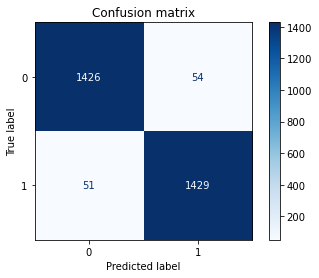



              precision    recall  f1-score   support

           0       0.97      0.96      0.96      1480
           1       0.96      0.97      0.96      1480

    accuracy                           0.96      2960
   macro avg       0.96      0.96      0.96      2960
weighted avg       0.96      0.96      0.96      2960



In [4]:
train_x, test_x,train_y, test_y = gen_data(file_path, ip_features, op_feature, train_size)

predict_probs, predict_vals, model, trunc_train_x, trunc_train_y = train_classifier("catboost",train_x, train_y, balance_type="downsample")

[[717670 514579]
 [   416    558]]


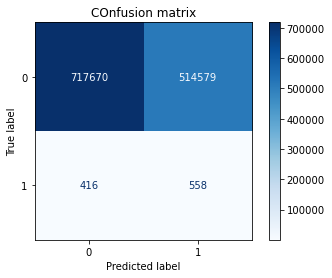





              precision    recall  f1-score   support

           0       1.00      0.58      0.74   1232249
           1       0.00      0.57      0.00       974

    accuracy                           0.58   1233223
   macro avg       0.50      0.58      0.37   1233223
weighted avg       1.00      0.58      0.74   1233223



In [5]:
test_preds = model.predict(test_x)
# confusion_mat = confusion_matrix(test_y, test_preds)
class_report = classification_report(test_y, test_preds)


disp = plot_confusion_matrix(model, test_x, test_y, cmap=plt.cm.Blues)
disp.ax_.set_title("COnfusion matrix")
print(disp.confusion_matrix)
plt.show()

print()
print()
# print("confusion Matrix")
# print(confusion_mat)
print()
print()
print(class_report)

## Feature Importance using Shapley Values

In [6]:
# trunc_train_x, trunc_train_y
explainer = shap.TreeExplainer(model)
features = trunc_train_x
# features.index = list(range(features.shape[0]))
shap_values = explainer.shap_values(features)

In [7]:
expected_value = explainer.expected_value
feature_display = features
shap_interaction_values = explainer.shap_interaction_values(features)

In [8]:
"Shap Force Plots"
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, features)

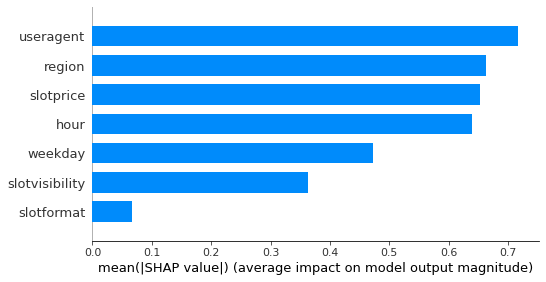

In [9]:
"Shap Feature Importance Plots"
shap.summary_plot(shap_values, features, plot_type="bar")

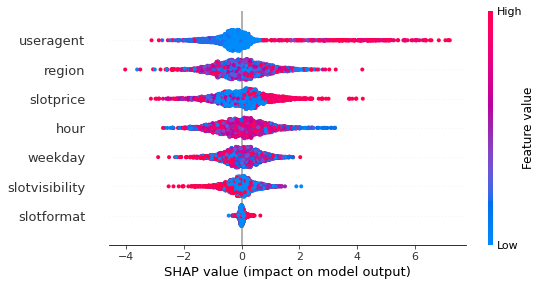

In [10]:
"Shap Summary Plot"
shap.summary_plot(shap_values, features)

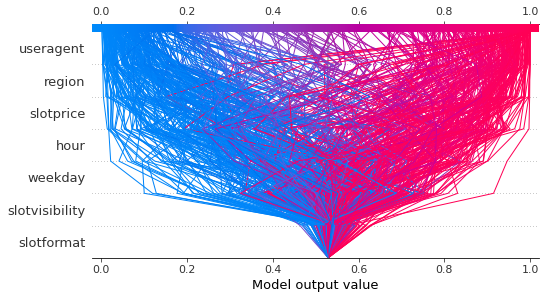

In [11]:
"Shap Decision Plots; using link='logit' to transform lig-odds to probabilities"
expected_value = explainer.expected_value
shap.decision_plot(expected_value, shap_values[::5], feature_display, link='logit', ignore_warnings=True)

In [12]:
expected_value

0.1164331327031825